# Introduction

Welcome to this notebook! This simple document showcases the power of Machine Learning in simulating and optimizing the behavior of a portfolio of assets to support optimal decision-making.

In this analysis, we will use historical data from five major technology companies—***Apple, Microsoft, AMD, Nvidia, and Google***—retrieved via **yfinance**. Our goal is to simulate the performance of a portfolio based on these assets and apply financial techniques for optimization.

The steps in this notebook are as follows:

**1) Data Analysis:Perform an in-depth analysis of the historical data to understand the risk and return characteristics of each asset.**

**2) Portfolio Optimization using Modern Portfolio Theory (MPT): Optimize the portfolio weights to achieve the best risk-return balance.**

**3) Simulating Portfolio Behavior for 2022: Use the optimized portfolio weights to simulate the portfolio's performance in 2022, based on the data from 2021.**


Through these steps, we will illustrate how machine learning and financial modeling can be applied to real-world data for effective portfolio management and decision-making.



In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=cd7d1606d1bfee3028a3760d790156a8adaac0950878d64d91a07b95a6399662
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import xgboost as xgb

from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


In [3]:
data = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2021-01-01', end='2022-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


# Data Analysis

Small Data Analysis to understand the asset selected 

In [4]:
print("Descriptive Statistics:")
returns.describe()

Descriptive Statistics:


Ticker,AAPL,AMD,GOOG,MSFT,NVDA
count,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.001409,0.002128,0.002166,0.001855,0.003625
std,0.015758,0.026843,0.014934,0.013206,0.028396
min,-0.041673,-0.061979,-0.045091,-0.036204,-0.082178
25%,-0.007518,-0.012312,-0.005270,-0.005438,-0.012083
50%,0.001474,0.000516,0.002292,0.000953,0.002502
75%,0.012455,0.016575,0.008988,0.010378,0.020192
max,0.053851,0.101364,0.073961,0.042114,0.120423


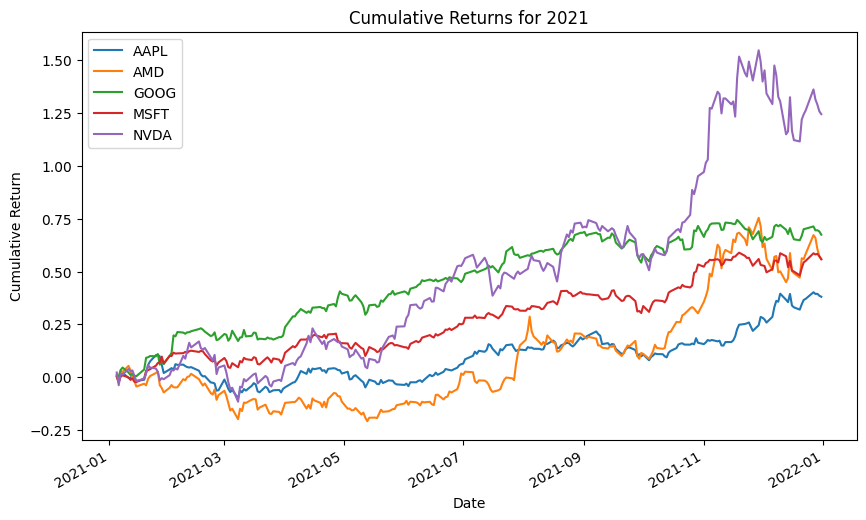

In [5]:
cumulative_returns = (1 + returns).cumprod() - 1
cumulative_returns.plot(figsize=(10, 6))
plt.title('Cumulative Returns for 2021')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(cumulative_returns.columns)
plt.show()

In [6]:
volatility = returns.std() * np.sqrt(252)  # Annualized volatility
print("\nAnnualized Volatility:")
volatility


Annualized Volatility:


Ticker
AAPL    0.250155
AMD     0.426119
GOOG    0.237068
MSFT    0.209631
NVDA    0.450773
dtype: float64

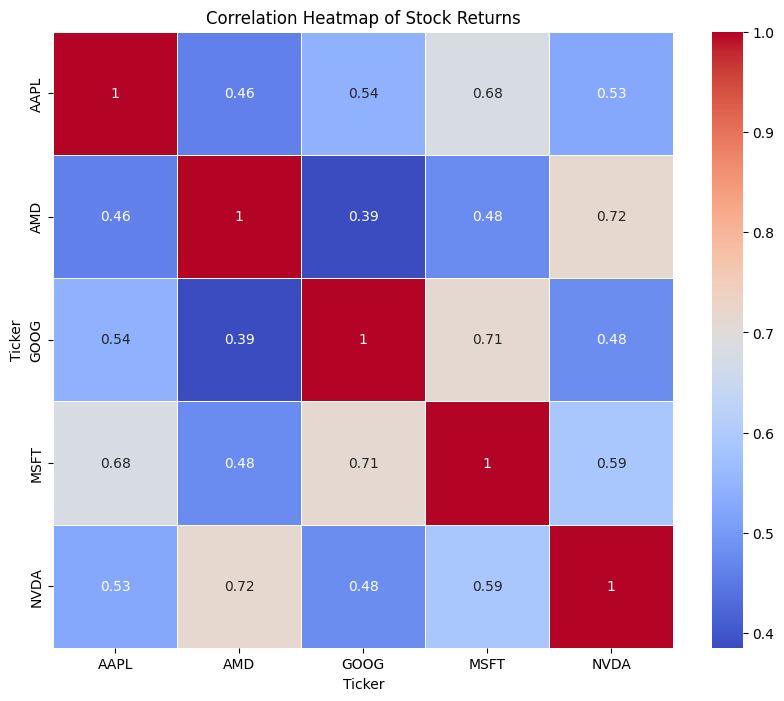

In [7]:
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Returns')
plt.show()


In [8]:
risk_free_rate = 0.03  # Assuming a 1% risk-free rate
mean_returns = returns.mean() * 252  # Annualized mean returns
sharpe_ratios = (mean_returns - risk_free_rate) / volatility
print("\nSharpe Ratios:")
print(sharpe_ratios)


Sharpe Ratios:
Ticker
AAPL    1.299889
AMD     1.187815
GOOG    2.175747
MSFT    2.086290
NVDA    1.959930
dtype: float64


In [9]:
confidence_level = 0.95
VaR = returns.quantile(1 - confidence_level)
CVaR = returns[returns <= VaR].mean()

print("\nValue at Risk (VaR) at 95% confidence level:")
print(VaR)
print("\nConditional Value at Risk (CVaR) at 95% confidence level:")
print(CVaR)



Value at Risk (VaR) at 95% confidence level:
Ticker
AAPL   -0.025653
AMD    -0.042933
GOOG   -0.023036
MSFT   -0.020817
NVDA   -0.040528
Name: 0.050000000000000044, dtype: float64

Conditional Value at Risk (CVaR) at 95% confidence level:
Ticker
AAPL   -0.033721
AMD    -0.054299
GOOG   -0.030241
MSFT   -0.027700
NVDA   -0.054134
dtype: float64


## Using CAPM and MPT for weights Optimization

In [10]:
data_ = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG','^IXIC'], start='2021-01-01', end='2022-01-01')
prices_ = data_['Adj Close']
returns_ = prices_.pct_change().dropna()

def Beta(ticker):
    R_i = returns_[ticker]
    R_m = returns_['^IXIC']
    cov_matrix = np.cov(R_i, R_m)
    covariance = cov_matrix[0, 1]
    variance_market = np.var(R_m)
    beta = covariance / variance_market
    return beta


def CAPM(ticker, beta):
    R_m = np.mean(returns_['^IXIC'])

    market_risk_premium = R_m - risk_free_rate

    expected_return = risk_free_rate + beta * market_risk_premium
    return expected_return

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

CAPM = [CAPM(ticker, Beta(ticker)) for ticker in returns_.columns]



expected_returns = np.array(CAPM)  
cov_matrix = returns_[['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG']].cov().to_numpy()  # Covariance matrix


# Using Modern portfolio theory (MPT),
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

initial_guess = [0.5, 0.5, 0.5,0.5,0.5]

optimal_result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal_result.x
print(f' Optimal Weights : {optimal_weights}')

[*********************100%***********************]  6 of 6 completed


 Optimal Weights : [3.01161658e-01 3.57351703e-01 0.00000000e+00 1.32272665e-17
 3.41486639e-01]


# Portfolio modelisation


## Modelisation using Rolling prediction

In [11]:
X = returns.shift(1).dropna()  
y = returns.shift(-1).dropna()  

X, y = X.align(y, join='inner', axis=0)


xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)

predicted_returns = multi_output_model.predict(X)
mse = mean_squared_error(y, predicted_returns)
rmse = np.sqrt(mse)
print(f"Multi-Output XGBoost RMSE: {rmse}")



Multi-Output XGBoost RMSE: 0.003861820050354782


In [12]:
def portfolio_volatility(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

def optimize_portfolio(predicted_returns, cov_matrix):
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(predicted_returns.shape[1])]
    initial_weights = np.array([1.0 / predicted_returns.shape[1]] * predicted_returns.shape[1])  # Equal weighting
    optimal_result = minimize(portfolio_volatility, initial_weights, args=(cov_matrix),
                              method='SLSQP', bounds=bounds, constraints=constraints)
    return optimal_result.x


predicted_cov_matrix = np.cov(predicted_returns, rowvar=False)
optimal_weights = optimize_portfolio(predicted_returns, predicted_cov_matrix)


predicted_portfolio_returns = np.dot(predicted_returns, optimal_weights)

print(f"Optimal weight: {optimal_weights}")


Optimal weight: [3.11969449e-01 0.00000000e+00 3.29175828e-01 3.58854723e-01
 1.99493200e-17]


Multi-Output XGBoost RMSE: 0.003861820050354782


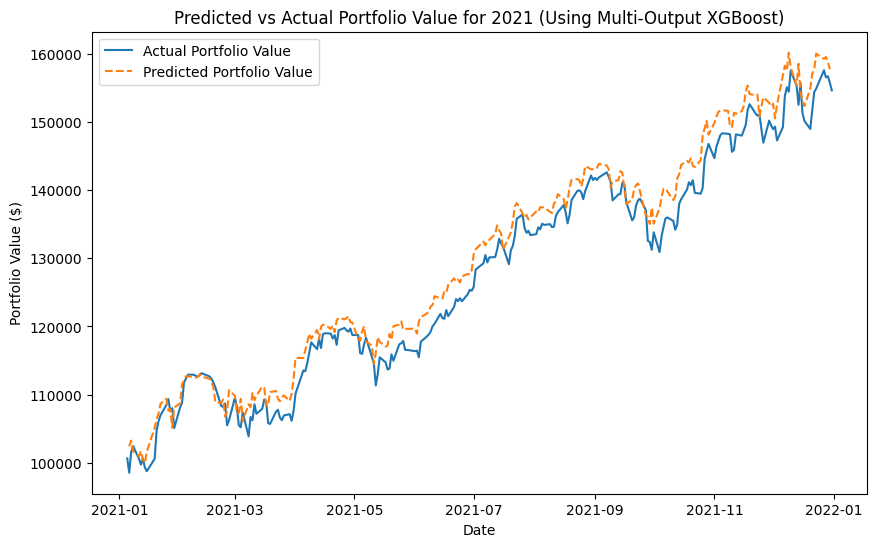

In [13]:
X = returns.shift(1).dropna()  
y = returns.shift(-1).dropna()  

X, y = X.align(y, join='inner', axis=0)


xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)

predicted_returns = multi_output_model.predict(X)
mse = mean_squared_error(y, predicted_returns)
rmse = np.sqrt(mse)
print(f"Multi-Output XGBoost RMSE: {rmse}")

portfolio_returns_actual = returns.dot(optimal_weights)
initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()

predicted_portfolio = predicted_returns.dot(optimal_weights)
predicted_portfolio_values = initial_portfolio_value * (1 + predicted_portfolio).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(returns.index, portfolio_values_actual, label='Actual Portfolio Value')
plt.plot(returns.index[1:-1], predicted_portfolio_values, label='Predicted Portfolio Value', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2021 (Using Multi-Output XGBoost)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


[*********************100%***********************]  5 of 5 completed


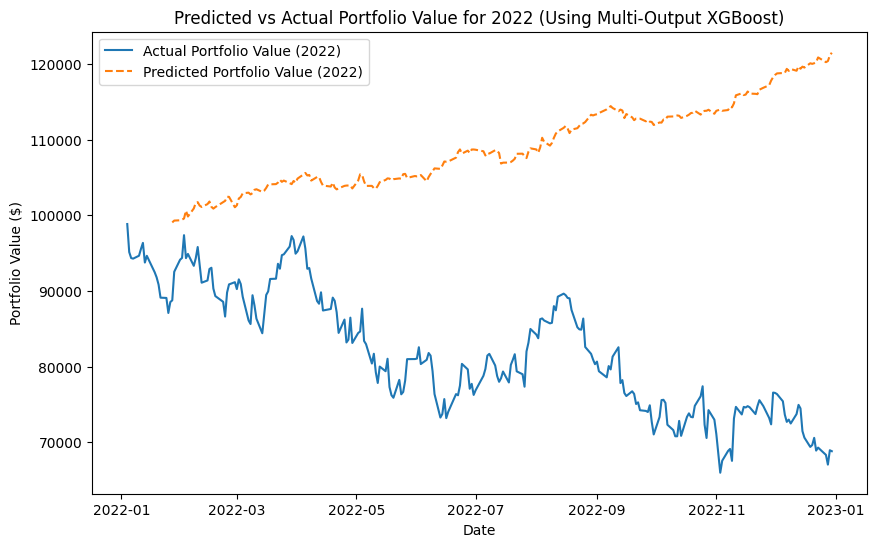

In [14]:
data_2022 = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2022-01-01', end='2023-01-01')
prices_2022 = data_2022['Adj Close']
returns_2022 = prices_2022.pct_change().dropna()

portfolio_returns_actual = returns_2022.dot(optimal_weights)
initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()


returns_jan_2022 = returns_2022.loc['2022-01-01':'2022-01-31']
X_jan_2022 = returns_jan_2022.shift(1).dropna()

predicted_portfolio_returns_2022 = []
current_X = X_jan_2022.iloc[-1, :].values.reshape(1, -1)  

# Rolling prediction
for i in range(252 - len(X_jan_2022)):
    next_day_returns = multi_output_model.predict(current_X)[0]
    predicted_portfolio_returns_2022.append(np.dot(next_day_returns, optimal_weights))


    current_X = next_day_returns.reshape(1, -1)

predicted_portfolio_values = initial_portfolio_value * (1 + np.array(predicted_portfolio_returns_2022)).cumprod()


plt.figure(figsize=(10, 6))
plt.plot(returns_2022.index, portfolio_values_actual, label='Actual Portfolio Value (2022)')
plt.plot(returns_2022.index[len(X_jan_2022)-2:], predicted_portfolio_values, label='Predicted Portfolio Value (2022)', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2022 (Using Multi-Output XGBoost)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Transfer-learning to predict the Behaviour for 1 week window

In [15]:
data = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2021-01-01', end='2022-01-01')
prices = data['Adj Close']
returns = prices.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


In [23]:
weekly_returns_2021 = returns.resample('W').apply(lambda x: (1 + x).prod() - 1).dropna()


X = weekly_returns_2021.shift(1).dropna()  # Lagged returns as features
y = weekly_returns_2021.shift(-1).dropna()  # Next week's returns for all assets
X, y = X.align(y, join='inner', axis=0)



xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
multi_output_model = MultiOutputRegressor(xg_reg)
multi_output_model.fit(X, y)



MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [114]:
data_2022 = yf.download(['AAPL', 'MSFT', 'AMD', 'NVDA', 'GOOG'], start='2022-01-01', end='2023-01-01')
prices_2022 = data_2022['Adj Close']
returns_2022 = prices_2022.pct_change().dropna()
weekly_returns_2022 = returns_2022.resample('W').apply(lambda x: (1 + x).prod() - 1).dropna()


predicted_returns_2022 = []


last_week_data = weekly_returns_2021.iloc[-1].values.reshape(1, -1)

# Weekly prediction and retraining loop 
for i in range(len(weekly_returns_2022)):

    next_week_returns = multi_output_model.predict(last_week_data)[0]
    predicted_returns_2022.append(next_week_returns)

    actual_returns_current_week = weekly_returns_2022.iloc[i].values.reshape(1, -1)
    last_week_data = actual_returns_current_week
    
    if i <= 2:
        combined_returns = pd.concat([weekly_returns_2021.iloc[-3+i:-1], weekly_returns_2022.iloc[:i+1]])
    else:
        combined_returns = weekly_returns_2022.iloc[i-2:i+1]
        

    new_X = combined_returns.shift(1).dropna()
    new_y = combined_returns.dropna()
 
 
    new_X, new_y = new_X.align(new_y, join='inner', axis=0)

    multi_output_model.fit(new_X.iloc[1:2], new_y.iloc[1:2])



[*********************100%***********************]  5 of 5 completed


In [115]:
weights = optimal_weights
predicted_returns_2022 = np.array(predicted_returns_2022)
predicted_portfolio_returns_2022 = predicted_returns_2022.dot(weights)

portfolio_returns_actual = weekly_returns_2022.dot(weights)

initial_portfolio_value = 100000
portfolio_values_actual = initial_portfolio_value * (1 + portfolio_returns_actual).cumprod()
predicted_portfolio_values = initial_portfolio_value * (1 + predicted_portfolio_returns_2022).cumprod()



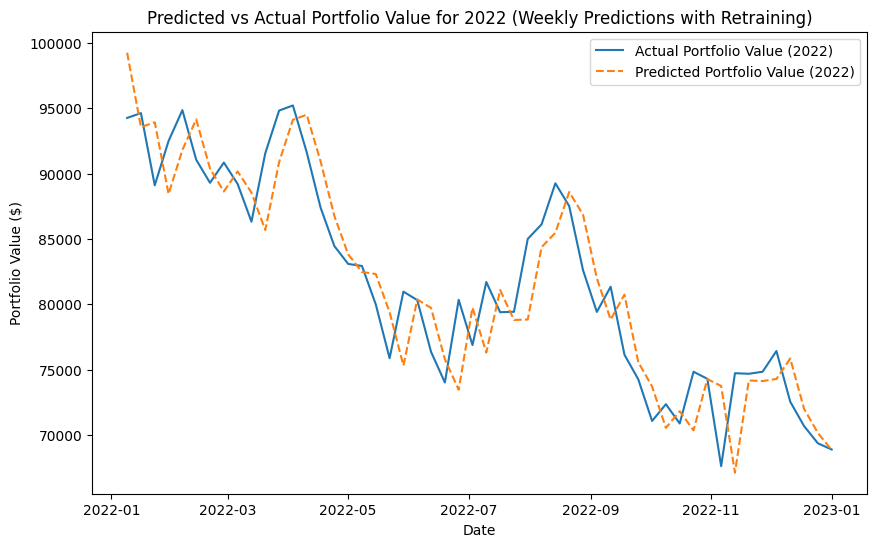

In [116]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_returns_2022.index, portfolio_values_actual, label='Actual Portfolio Value (2022)')
plt.plot(weekly_returns_2022.index, predicted_portfolio_values, label='Predicted Portfolio Value (2022)', linestyle='dashed')
plt.title('Predicted vs Actual Portfolio Value for 2022 (Weekly Predictions with Retraining)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
